In [1]:
from scipy.stats import ttest_ind
import pandas as pd
import seaborn as sb
import numpy as np
import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist as fdist
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt

In [2]:
pip install openpyxl

  Using cached openpyxl-3.0.10-py2.py3-none-any.whl (242 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Note: you may need to restart the kernel to use updated packages.


# Data cleaning and integration

In [3]:
behaviour = pd.read_csv("QVI_purchase_behaviour.csv")

transaction = pd.read_excel("QVI_transaction_data.xlsx")


In [4]:
behaviour.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [5]:
transaction.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


## First dive into the behaviour data 

In [6]:
behaviour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


For the behaviour data, we have three columns (and 72637 rows) with no missing values, next let's see what each column actually means

In [7]:
behaviour['LYLTY_CARD_NBR'].unique()
print(len(behaviour['LYLTY_CARD_NBR'].unique()))

72637


It can be seen that the card numebr is the unique key for the dataset behaviour

In [8]:
behaviour['LIFESTAGE'].unique()

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

The unique values indicates different age-types of customers, values are consistency

In [9]:
behaviour['PREMIUM_CUSTOMER'].unique()

array(['Premium', 'Mainstream', 'Budget'], dtype=object)

The unique values indicates different types of customers, values are consistency

The behaviour data is consistent, no missing value, the data is cleaned

## Next, the transaction data

In [10]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


The dataset has no missing values. Note that the date is in int64 type.
Need to correct the date into date-type

In [11]:
transaction_copy = transaction.copy()

In [12]:
transaction_copy.DATE = pd.to_datetime(transaction_copy['DATE'], origin = "1899-12-30", unit='D')

Next, check if other columns are consistent

In [13]:
transaction_copy['STORE_NBR'].unique()

array([  1,   2,   4,   5,   7,   8,   9,  13,  19,  20,  22,  23,  25,
        33,  36,  38,  39,  41,  43,  45,  51,  54,  55,  56,  58,  59,
        60,  62,  63,  67,  71,  72,  74,  75,  80,  81,  82,  83,  84,
        88,  94,  96,  97, 101, 102, 104, 106, 109, 110, 111, 112, 114,
       115, 116, 118, 119, 120, 122, 125, 128, 129, 130, 133, 149, 151,
       152, 153, 156, 157, 160, 161, 164, 166, 167, 168, 169, 172, 173,
       175, 178, 181, 184, 186, 187, 191, 194, 196, 197, 200, 205, 207,
       208, 209, 212, 214, 215, 216, 217, 219, 222, 223, 225, 226, 227,
       235, 236, 237, 241, 243, 246, 247, 248, 250, 253, 255, 256, 257,
       262, 265, 266, 269, 271,  77,   3,   6,  10,  12,  15,  16,  17,
        18,  21,  24,  26,  27,  28,  29,  30,  32,  34,  35,  37,  40,
        46,  47,  48,  49,  50,  52,  53,  57,  61,  64,  65,  66,  68,
        69,  70,  73,  78,  79,  86,  87,  89,  90,  91,  93,  95,  98,
       100, 103, 105, 107, 108, 113, 117, 121, 123, 124, 126, 12

This column indicates different stores. Values are consistent

In [14]:
len(transaction_copy['LYLTY_CARD_NBR'].unique())

72637

Note that we all customers in the customer data has a transaction record

In [15]:
transaction_copy['TXN_ID'].nunique()

263127

The number of uniques TXN_ID is 263127, not equal to 264835: there must be duplicated TXN_ID

In [16]:
transaction_copy[transaction_copy.duplicated(['TXN_ID'])]['TXN_ID'].unique().shape

(1702,)

In [17]:
transaction_copy[transaction_copy.duplicated(['TXN_ID'])].head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
42,2019-05-20,55,55073,48887,113,Twisties Chicken270g,1,4.6
377,2019-01-10,7,7364,7739,20,Doritos Cheese Supreme 330g,2,11.4
419,2018-10-18,12,12301,10982,93,Doritos Corn Chip Southern Chicken 150g,2,7.8
476,2018-09-08,16,16427,14546,81,Pringles Original Crisps 134g,1,3.7
511,2018-08-03,19,19272,16683,31,Infzns Crn Crnchers Tangy Gcamole 110g,2,7.6


In [18]:
transaction_copy.loc[transaction_copy['TXN_ID']==10982].head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
418,2018-10-18,12,12301,10982,50,Tostitos Lightly Salted 175g,2,8.8
419,2018-10-18,12,12301,10982,93,Doritos Corn Chip Southern Chicken 150g,2,7.8


In one transaction, different products are purchased.Thus, TXN_ID are duplicated 

The product are a little messy: & and / exist

In [19]:
#Use regular expression to extract out the weight
transaction_copy['PACK_WEIGHT'] = transaction_copy['PROD_NAME'].str.extract("(\d+)")
transaction_copy['PACK_WEIGHT'] = pd.to_numeric(transaction_copy['PACK_WEIGHT'])
transaction_copy['PACK_WEIGHT'].unique() 

array([175, 170, 150, 300, 330, 210, 270, 220, 125, 110, 134, 380, 180,
       165, 135, 250, 200, 160, 190,  90,  70])

The pack weight looks fine, no outliers

In [20]:
transaction_copy

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_WEIGHT
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150
...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150


In [21]:
import re

In [22]:
def clean_text(text):
    text = re.sub('[&/]', ' ', text)
    text = re.sub('\d\w*', ' ', text)   #\d - Matches any decimal digit. Equivalent to [0-9],The star symbol * matches zero or more occurrences of the pattern left to it. \wMatches any alphanumeric character

    return text
transaction_copy['PROD_NAME'] = transaction_copy['PROD_NAME'].apply(clean_text)

In [23]:
transaction_copy['PROD_NAME']

0           Natural Chip        Compny SeaSalt 
1                         CCs Nacho Cheese     
2           Smiths Crinkle Cut  Chips Chicken  
3           Smiths Chip Thinly  S Cream Onion  
4         Kettle Tortilla ChpsHny Jlpno Chili  
                          ...                  
264831     Kettle Sweet Chilli And Sour Cream  
264832               Tostitos Splash Of  Lime  
264833                    Doritos Mexicana     
264834     Doritos Corn Chip Mexican Jalapeno  
264835               Tostitos Splash Of  Lime  
Name: PROD_NAME, Length: 264836, dtype: object

In [24]:
transaction_copy['PROD_NAME'] = transaction_copy.PROD_NAME.str.strip()

In [25]:
transaction_copy['PROD_NAME'] = transaction_copy.PROD_NAME.replace(r'\s+', ' ', regex=True)

In [26]:
transaction_copy['PROD_NAME'].head(100)

0             Natural Chip Compny SeaSalt
1                        CCs Nacho Cheese
2        Smiths Crinkle Cut Chips Chicken
3        Smiths Chip Thinly S Cream Onion
4     Kettle Tortilla ChpsHny Jlpno Chili
                     ...                 
95                          Kettle Chilli
96                       Doritos Mexicana
97           Thins Potato Chips Hot Spicy
98     Cobs Popd Swt Chlli Sr Cream Chips
99                 WW Crinkle Cut Chicken
Name: PROD_NAME, Length: 100, dtype: object

In [27]:
transaction_copy['PROD_NAME'] = transaction_copy.PROD_NAME.str.strip()

In [28]:
transaction_copy['PROD_NAME'].head(100)

0             Natural Chip Compny SeaSalt
1                        CCs Nacho Cheese
2        Smiths Crinkle Cut Chips Chicken
3        Smiths Chip Thinly S Cream Onion
4     Kettle Tortilla ChpsHny Jlpno Chili
                     ...                 
95                          Kettle Chilli
96                       Doritos Mexicana
97           Thins Potato Chips Hot Spicy
98     Cobs Popd Swt Chlli Sr Cream Chips
99                 WW Crinkle Cut Chicken
Name: PROD_NAME, Length: 100, dtype: object

In [29]:
transaction_copy.head(150)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_WEIGHT
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt,2,6.0,175
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese,3,6.3,175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S Cream Onion,5,15.0,175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny Jlpno Chili,3,13.8,150
...,...,...,...,...,...,...,...,...,...
145,2019-05-15,197,197172,197097,72,WW Crinkle Cut Original,1,1.7,175
146,2018-08-18,200,200162,199522,114,Kettle Sensations Siracha Lime,1,4.6,150
147,2018-08-16,205,205151,204218,74,Tostitos Splash Of Lime,1,4.4,175
148,2019-05-15,205,205151,204219,82,Smith Crinkle Cut Mac N Cheese,3,7.8,150


In [30]:
import seaborn as sns

In [31]:
from matplotlib.pyplot import figure
figure(figsize=(26, 26), dpi=80)

<Figure size 2080x2080 with 0 Axes>

<Figure size 2080x2080 with 0 Axes>

Text(0.5, 1.0, 'Pack Size Histogram')

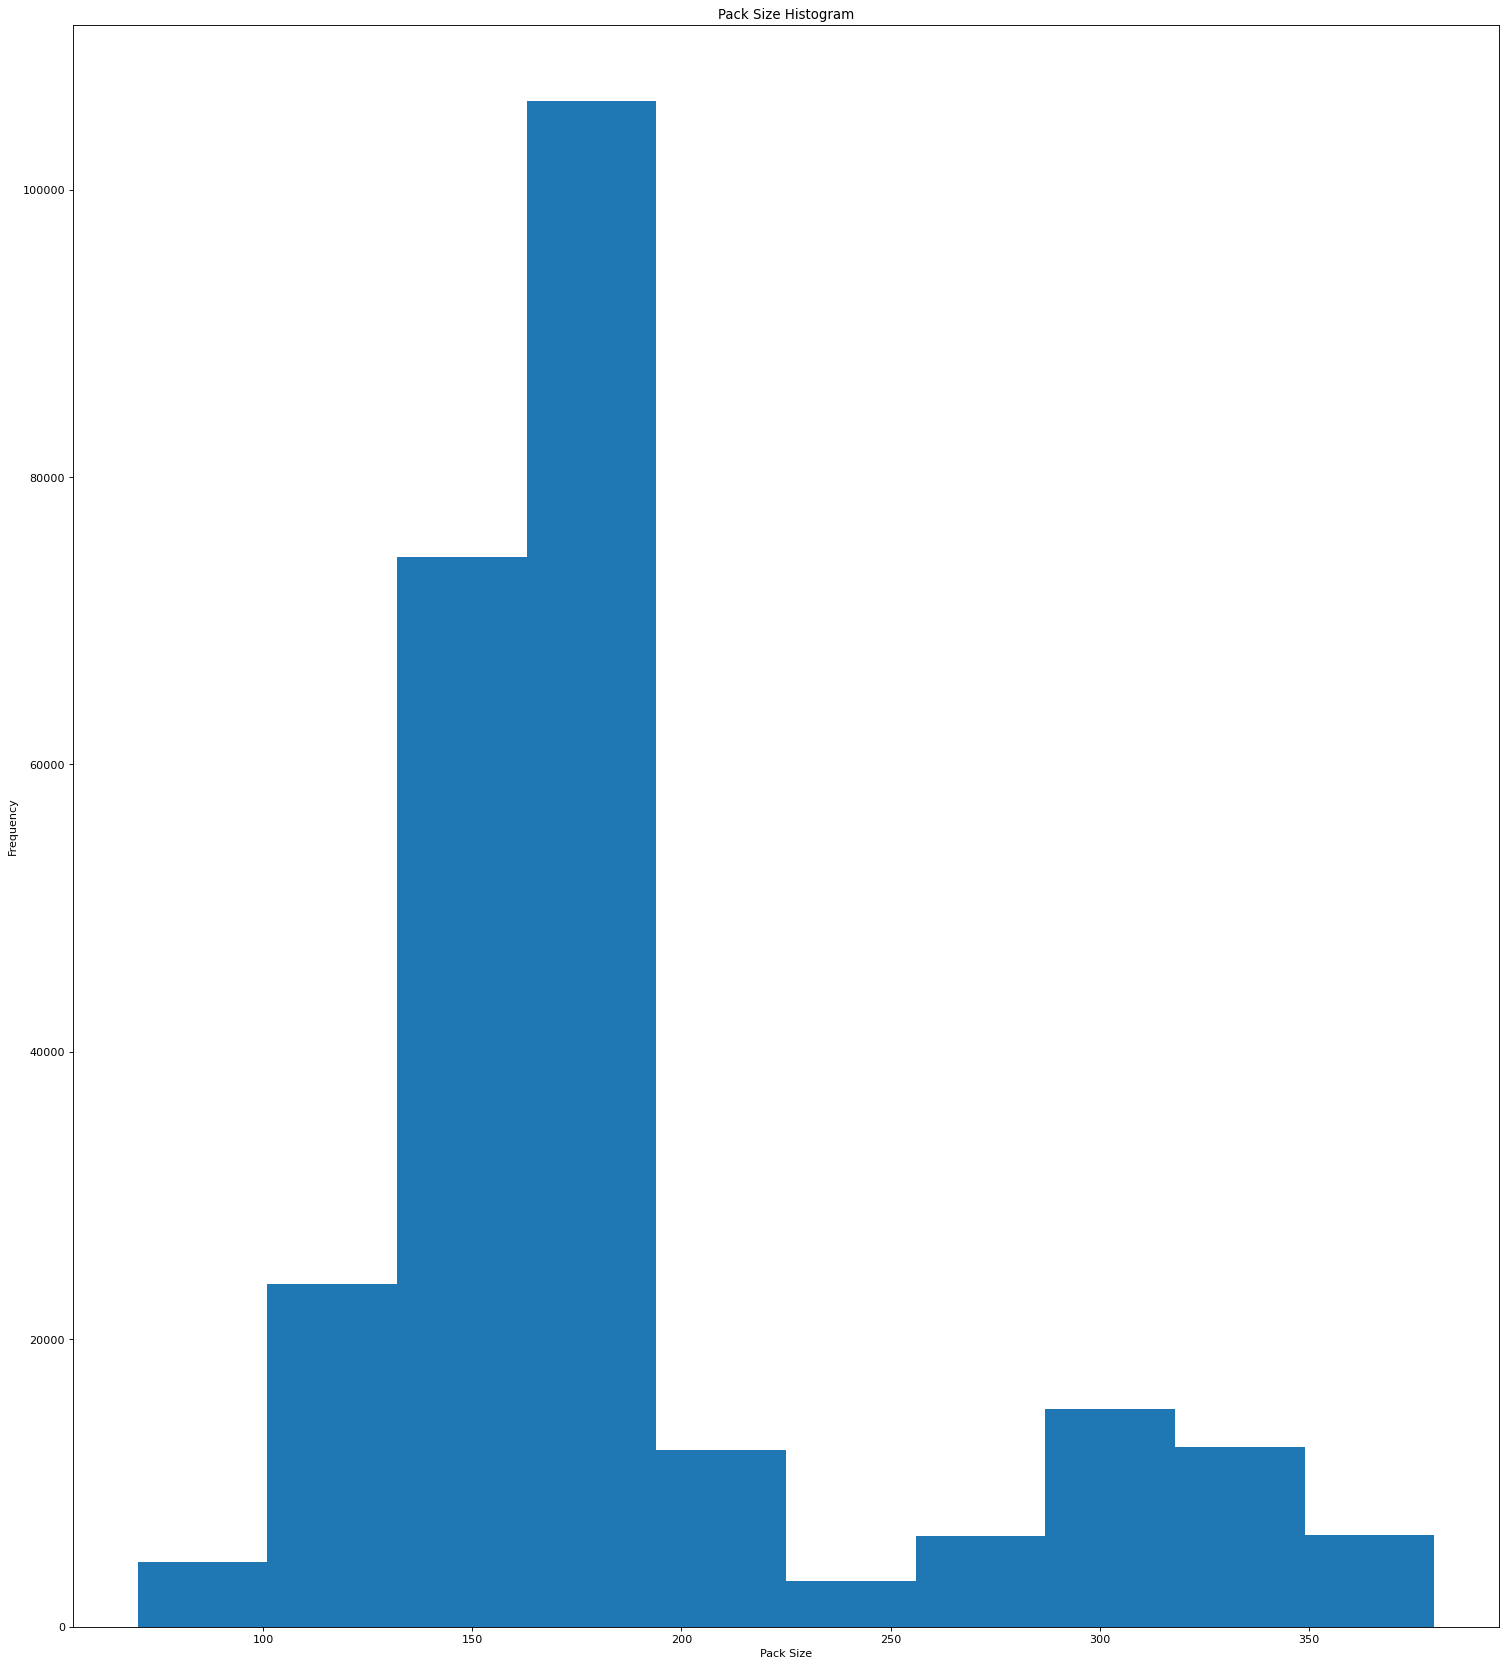

In [32]:
figure(figsize=(23, 26), dpi=80)
#sns.histplot(data = transaction_copy, x = 'PACK_WEIGHT')
plt.hist(transaction_copy['PACK_WEIGHT'])
plt.xlabel('Pack Size')
plt.ylabel('Frequency')
plt.title('Pack Size Histogram')

<AxesSubplot:xlabel='TOT_SALES'>

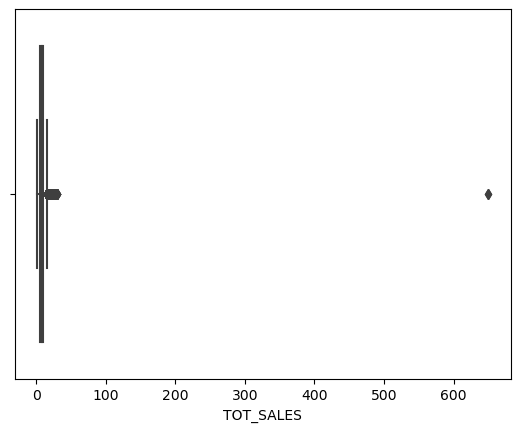

In [33]:
sns.boxplot(x=transaction_copy["TOT_SALES"])

Note that there is one outlier for total sales

In [34]:
transaction_copy[transaction_copy['TOT_SALES']>600]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_WEIGHT
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme,200,650.0,380
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme,200,650.0,380


The reason why TOT_SALES is super large is that prod_qty is 200
It is likely that these two transactions are retails transactions

If we are going to calculate the mean or counduct regression, these outliers should be removed

<AxesSubplot:xlabel='PROD_QTY'>

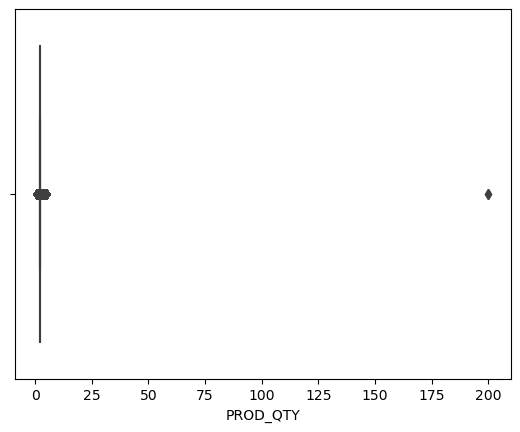

In [35]:
sns.boxplot(x=transaction_copy["PROD_QTY"])

We can see that for PROD_QTY, the only outlier is 200

In [36]:
transaction_copy = transaction_copy[transaction_copy['TOT_SALES']<600]

In [37]:
part = transaction_copy['PROD_NAME'].str.partition()
transaction_copy['BRAND'] = part[0]
transaction_copy['BRAND'].unique()

/tmp/ipykernel_46/3583931684.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_copy['BRAND'] = part[0]


array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Old', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'Woolworths', 'French', 'RRD', 'Tostitos',
       'Cheetos', 'Snbts', 'Sunbites'], dtype=object)

Note that the brand names are not consistency. Manually edit them.

In [38]:
transaction_copy['BRAND'].replace('Ncc', 'Natural', inplace = True)
transaction_copy['BRAND'].replace('Ccs', 'CCS', inplace = True)
transaction_copy['BRAND'].replace('Smith', 'Smiths', inplace = True)
transaction_copy['BRAND'].replace(['Grain', 'Grnwves'], 'Grainwaves', inplace = True)
transaction_copy['BRAND'].replace('Dorito', 'Doritos', inplace = True)
transaction_copy['BRAND'].replace('Ww', 'Woolworths', inplace = True)
transaction_copy['BRAND'].replace('Infzns', 'Infuzions', inplace = True)
transaction_copy['BRAND'].replace(['Red', 'Rrd'], 'Red Rock Deli', inplace = True)
transaction_copy['BRAND'].replace('Snbts', 'Sunbites', inplace = True)


/tmp/ipykernel_46/3608510193.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_copy['BRAND'].replace('Ncc', 'Natural', inplace = True)
/tmp/ipykernel_46/3608510193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_copy['BRAND'].replace('Ccs', 'CCS', inplace = True)
/tmp/ipykernel_46/3608510193.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_copy['BRAND'].replace('Smith', 'Smiths', inplace = T

In [39]:
transaction_copy['BRAND'].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Old', 'Grainwaves',
       'Doritos', 'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels',
       'Infuzions', 'Red Rock Deli', 'Pringles', 'GrnWves', 'Tyrrells',
       'Cobs', 'Woolworths', 'French', 'RRD', 'Tostitos', 'Cheetos',
       'Sunbites'], dtype=object)

Delete products salsa since we are interested in chips

In [40]:
transaction_copy['PROD_NAME'] = transaction_copy['PROD_NAME'].apply(lambda x: x.lower())
transaction_copy = transaction_copy[~transaction_copy['PROD_NAME'].str.contains("salsa")]

/tmp/ipykernel_46/2223648185.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_copy['PROD_NAME'] = transaction_copy['PROD_NAME'].apply(lambda x: x.lower())


Is there any missing dates in the transaction data ? 

In [41]:
pd.date_range(start = '2018-07-01', end = '2019-06-30').difference(transaction_copy['DATE'])

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

On the Chrismas day in 2018, the data is missing, which is reasonable since the stores were closed

Now the dataset is cleaned: i.e. No missing data, texts are consistent and there is no outlier

Next, we can dive into the Exploratory Data Analysis

# EDA

 ## First, let's see some facts about out customers

Deep down into customer demographic in each type:　
1. How many members in each group
   ---> Specifcally, howm many customers in each age-group in each type
2. The proportion of age group in each type


Text(0, 0.5, 'Premium Customer')

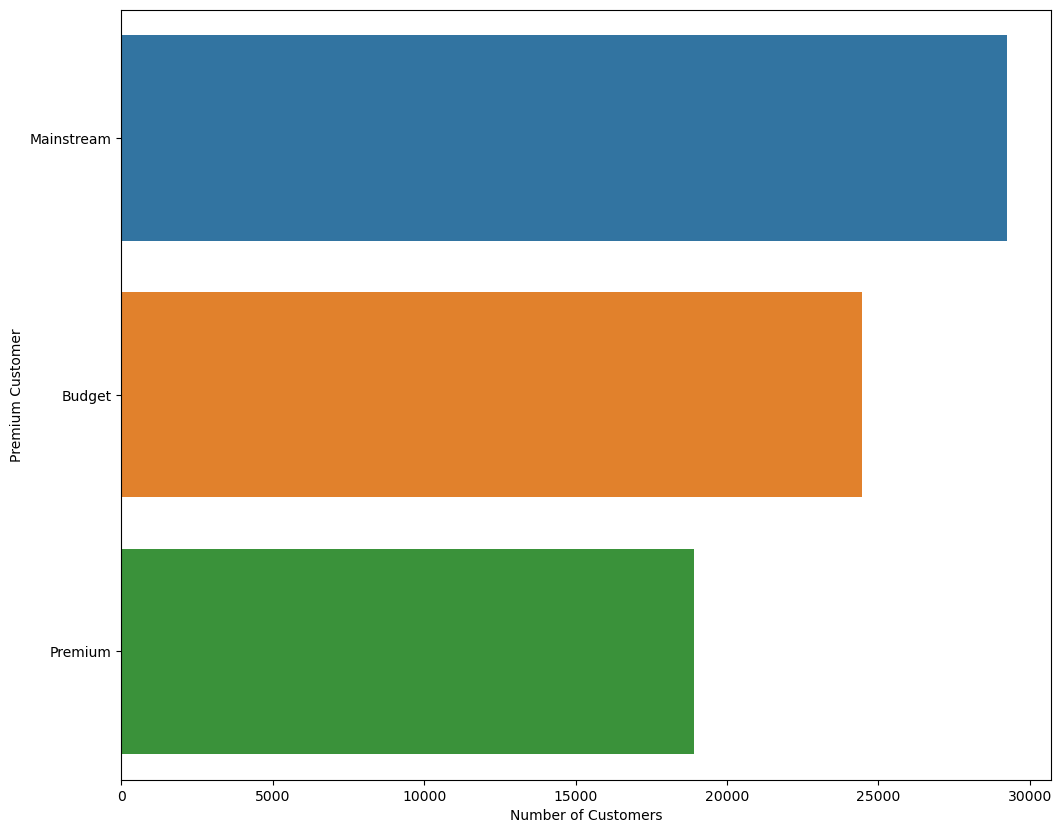

In [42]:
plt.figure(figsize = (12, 10))
sns.countplot(y = behaviour['PREMIUM_CUSTOMER'], order = behaviour['PREMIUM_CUSTOMER'].value_counts().index)
plt.xlabel('Number of Customers')
plt.ylabel('Premium Customer')

The mainstream type has the most customers

In [134]:
customer_count = pd.DataFrame(behaviour.groupby(['PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].count())

In [135]:
customer_count

,LYLTY_CARD_NBR
PREMIUM_CUSTOMER,
Budget,24470
Mainstream,29245
Premium,18922


In [136]:
customer_count['Proportion'] = customer_count['LYLTY_CARD_NBR']/customer_count['LYLTY_CARD_NBR'].sum()

In [137]:
customer_count

,LYLTY_CARD_NBR,Proportion
PREMIUM_CUSTOMER,,
Budget,24470,0.336881
Mainstream,29245,0.402619
Premium,18922,0.260501


### Customer Count by LifeStage

In [139]:
customer_count = pd.DataFrame(behaviour.groupby(['LIFESTAGE'])['LYLTY_CARD_NBR'].count())

In [140]:
customer_count['Proportion'] = customer_count['LYLTY_CARD_NBR']/customer_count['LYLTY_CARD_NBR'].sum()

In [142]:
customer_count.sort_values(by = 'LYLTY_CARD_NBR', ascending = False, inplace = True)

In [143]:
customer_count

,LYLTY_CARD_NBR,Proportion
LIFESTAGE,,
RETIREES,14805,0.203822
OLDER SINGLES/COUPLES,14609,0.201123
YOUNG SINGLES/COUPLES,14441,0.198811
OLDER FAMILIES,9780,0.134642
YOUNG FAMILIES,9178,0.126354
MIDAGE SINGLES/COUPLES,7275,0.100156
NEW FAMILIES,2549,0.035092


<AxesSubplot:xlabel='count', ylabel='LIFESTAGE'>

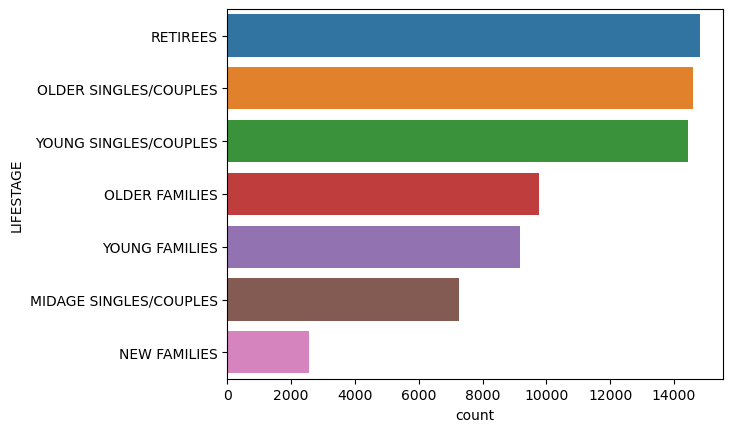

In [43]:
sns.countplot(y = behaviour['LIFESTAGE'], order = behaviour['LIFESTAGE'].value_counts().index)

Text(0, 0.5, 'Premium Customer')

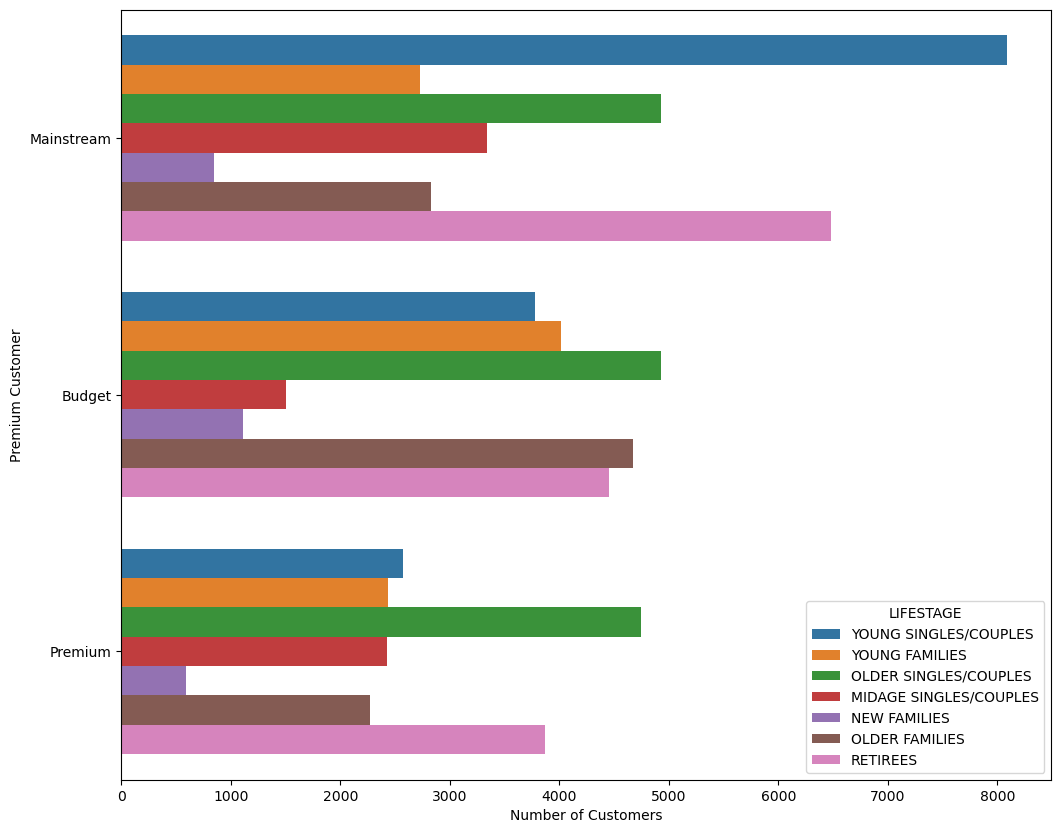

In [44]:
plt.figure(figsize = (12, 10))
sns.countplot(y = behaviour['PREMIUM_CUSTOMER'], order = behaviour['PREMIUM_CUSTOMER'].value_counts().index,hue = behaviour['LIFESTAGE'])
plt.xlabel('Number of Customers')
plt.ylabel('Premium Customer')

The TOP3 age groups in each type of custoemrs:
1. Mainstram: Young Singles/Couples, Retirees, Older Singles/Couples
2. Budget: Older Singles/Couples, Older Families, Retirees
3. Premium: Older Singles/Couples, Retirees, Young Singles/Couples

Conclusion: 
1. The TOP3 age groups for mainstream and premium are the same:  Young Singles/Couples, Retirees, Older Singles/Couples
2. For top3 age groups in all types, elder people always exists. More specifically, In the budget type, all types are elder people.


## EDA for transaction_data

In [45]:
pt1 =  pd.pivot_table(transaction_copy, values = 'TOT_SALES', index = 'DATE', aggfunc = 'sum')
pt1_tmp = pd.DataFrame(index = pd.date_range(start = '2018-07-01', end = '2019-06-30'))
pt1_tmp['TOT_SALES'] = 0
pt1_final= pt1 + pt1_tmp
pt1_final.fillna(0, inplace = True)


In [145]:
pt1_final.index.name = 'Date'
pt1_final.rename(columns = {'TOT_SALES': 'Total Sales'}, inplace = True)
pt1_final.head() 

,Total Sales
Date,
2018-07-01,4920.1
2018-07-02,4877.0
2018-07-03,4954.7
2018-07-04,4968.1
2018-07-05,4682.0


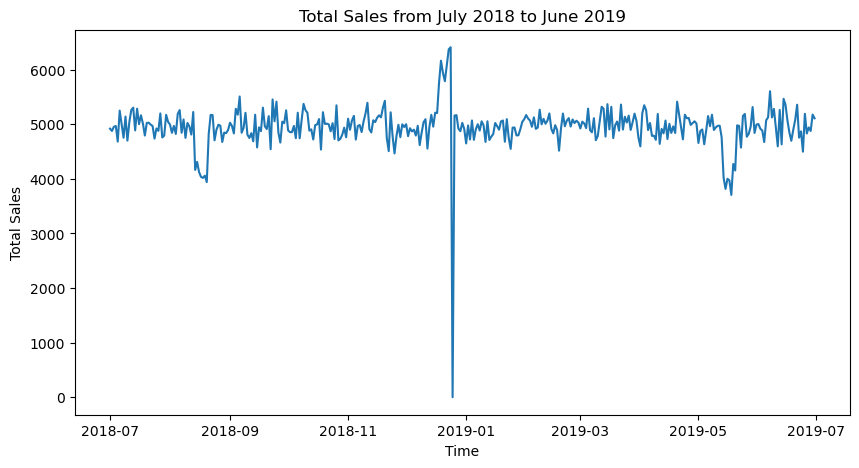

In [47]:
timeline = pt1_final.index
graph = pt1_final['Total Sales']

fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(timeline, graph)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.title('Total Sales from July 2018 to June 2019')
plt.xlabel('Time')
plt.ylabel('Total Sales')

plt.show()


### Sales Dropfall Analysis

In [149]:
pt1_final = pt1_final.reset_index(level='Date')

In [151]:
pt1_final[pt1_final['Date']>'2018-07-01']

,Date,Total Sales
1,2018-07-02,4877.0
2,2018-07-03,4954.7
3,2018-07-04,4968.1
4,2018-07-05,4682.0
5,2018-07-06,5249.4
...,...,...
360,2019-06-26,4829.7
361,2019-06-27,4941.3
362,2019-06-28,4876.6
363,2019-06-29,5177.6


# Customer Analytics

In [48]:
#To simplify the data analytics process, merge two dataset
data = pd.merge(transaction_copy, behaviour)

In [49]:
behaviour.shape

(72637, 3)

In [50]:
transaction_copy.shape

(246740, 10)

In [51]:
data.shape

(246740, 12)

## What groups contributes the largest proportion of sales ?

####  Sales contribution by customer types

In [52]:
sales_ct = pd.DataFrame(data.groupby(['PREMIUM_CUSTOMER']).TOT_SALES.sum())
sales_ct.rename(columns = {'TOT_SALES': 'Total Sales'}, inplace = True)
sales_ct.sort_values(by = 'Total Sales', ascending = False, inplace = True)
sales_ct

,Total Sales
PREMIUM_CUSTOMER,
Mainstream,700865.40
Budget,631406.85
Premium,472905.45


In [53]:
sales_ct['Proportion'] = sales_ct['Total Sales']/sales_ct['Total Sales'].sum()
sales_ct.sort_values(by = 'Proportion', ascending = False)

,Total Sales,Proportion
PREMIUM_CUSTOMER,,
Mainstream,700865.40,0.388253
Budget,631406.85,0.349775
Premium,472905.45,0.261972


In [54]:
sales_ct['Proportion'] = sales_ct['Total Sales']/sales_ct['Total Sales'].sum()

In [55]:
sales_ct.sort_values(by = 'Proportion', ascending = False)

,Total Sales,Proportion
PREMIUM_CUSTOMER,,
Mainstream,700865.40,0.388253
Budget,631406.85,0.349775
Premium,472905.45,0.261972


In [56]:
sales_ct['Proportion Sum'] = sales_ct.Proportion.cumsum()

In [57]:
sales_ct

,Total Sales,Proportion,Proportion Sum
PREMIUM_CUSTOMER,,,
Mainstream,700865.40,0.388253,0.388253
Budget,631406.85,0.349775,0.738028
Premium,472905.45,0.261972,1.000000


##### Insight: The mainstream type contributes the most sales

In [58]:
sales_ls = pd.DataFrame(data.groupby(['LIFESTAGE']).TOT_SALES.sum())
sales_ls.rename(columns = {'TOT_SALES': 'Total Sales'}, inplace = True)
sales_ls.sort_values(by = 'Total Sales', ascending = False, inplace = True)
sales_ls

,Total Sales
LIFESTAGE,
OLDER SINGLES/COUPLES,376019.65
RETIREES,342381.90
OLDER FAMILIES,328519.90
YOUNG FAMILIES,294627.90
YOUNG SINGLES/COUPLES,243756.60
MIDAGE SINGLES/COUPLES,172523.80
NEW FAMILIES,47347.95


In [59]:
sales_ls['Proportion'] = sales_ls['Total Sales']/sales_ls['Total Sales'].sum()
sales_ls.sort_values(by = 'Proportion', ascending = False)

,Total Sales,Proportion
LIFESTAGE,,
OLDER SINGLES/COUPLES,376019.65,0.208301
RETIREES,342381.90,0.189667
OLDER FAMILIES,328519.90,0.181988
YOUNG FAMILIES,294627.90,0.163213
YOUNG SINGLES/COUPLES,243756.60,0.135032
MIDAGE SINGLES/COUPLES,172523.80,0.095572
NEW FAMILIES,47347.95,0.026229


In [60]:
sales_ls['Proportion Sum'] = sales_ls.Proportion.cumsum()

In [61]:
sales_ls

,Total Sales,Proportion,Proportion Sum
LIFESTAGE,,,
OLDER SINGLES/COUPLES,376019.65,0.208301,0.208301
RETIREES,342381.90,0.189667,0.397967
OLDER FAMILIES,328519.90,0.181988,0.579955
YOUNG FAMILIES,294627.90,0.163213,0.743167
YOUNG SINGLES/COUPLES,243756.60,0.135032,0.878199
MIDAGE SINGLES/COUPLES,172523.80,0.095572,0.973771
NEW FAMILIES,47347.95,0.026229,1.000000


#####  Insight: The elder people contributes higher sales: OLDER SINGLES/COUPLES	,RETIREES	,OLDER FAMILIES	

## Customer counts by type and age group

In [63]:
# Number of customers by PREMIUM_CUSTOMER and LIFESTAGE

customers = pd.DataFrame(data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).LYLTY_CARD_NBR.nunique())
customers.rename(columns = {'LYLTY_CARD_NBR': 'Number of Customers'}, inplace = True)
customers.sort_values(by = 'Number of Customers', ascending = False).head(10)

Number of Customers
PREMIUM_CUSTOMER LIFESTAGE                                 
Mainstream       YOUNG SINGLES/COUPLES                 7917
                 RETIREES                              6358
                 OLDER SINGLES/COUPLES                 4858
Budget           OLDER SINGLES/COUPLES                 4849
Premium          OLDER SINGLES/COUPLES                 4682
Budget           OLDER FAMILIES                        4611
                 RETIREES                              4385
                 YOUNG FAMILIES                        3953
Premium          RETIREES                              3812
Budget           YOUNG SINGLES/COUPLES                 3647

<Figure size 1600x1800 with 0 Axes>

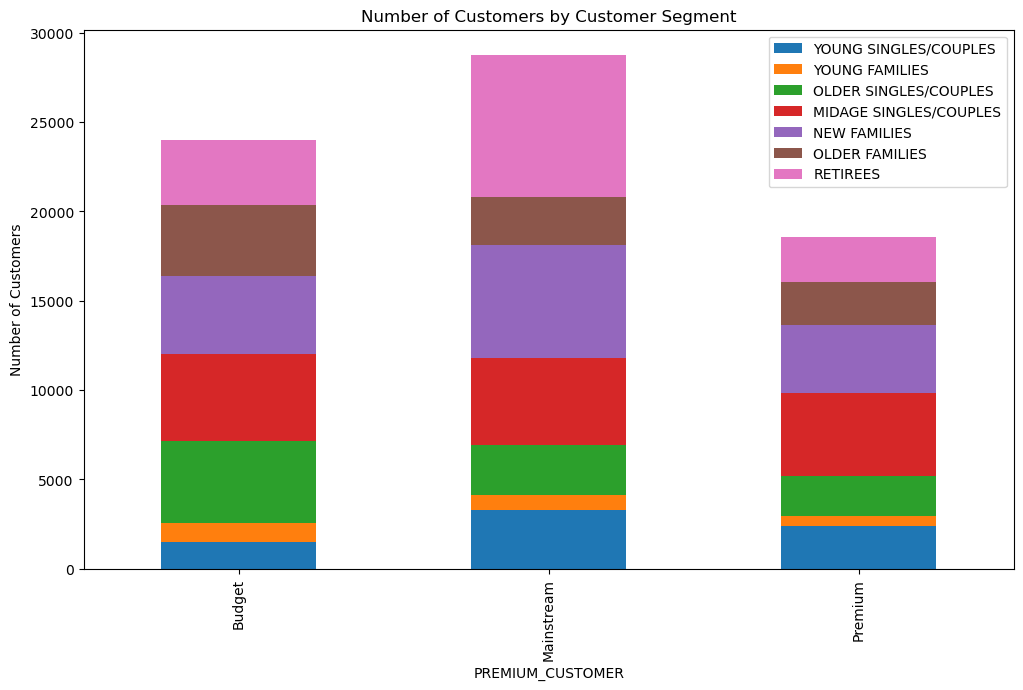

In [64]:
# Visualise
plt.figure(figsize = (16, 18))
customersPlot = pd.DataFrame(data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).LYLTY_CARD_NBR.nunique())
customersPlot.unstack().plot(kind = 'bar', stacked = True, figsize = (12, 7), title = 'Number of Customers by Customer Segment')
plt.ylabel('Number of Customers')
plt.legend(behaviour['LIFESTAGE'].unique(), loc = 1)

## Total_sales by each type of customer

In [65]:
tot_sales_by_type = pd.DataFrame(data.groupby(['PREMIUM_CUSTOMER']).TOT_SALES.sum())
tot_sales_by_type = tot_sales_by_type.reset_index(level=['PREMIUM_CUSTOMER'])

In [66]:
tot_sales_by_type

,PREMIUM_CUSTOMER,TOT_SALES
0,Budget,631406.85
1,Mainstream,700865.40
2,Premium,472905.45


In [67]:
tot_sales_by_type.sort_values(by = 'TOT_SALES', ascending = False, inplace = True)

<AxesSubplot:xlabel='PREMIUM_CUSTOMER', ylabel='TOT_SALES'>

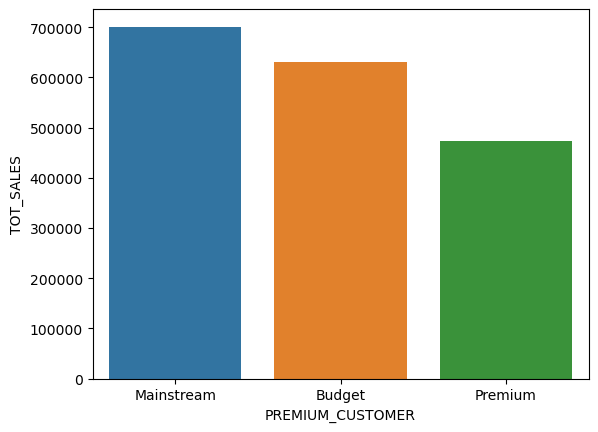

In [68]:
sns.barplot(y = tot_sales_by_type['TOT_SALES'],x=tot_sales_by_type['PREMIUM_CUSTOMER'])

Mainstream has the largest sales

## Total Sales by PREMIUM_CUSTOMER and LIFESTAGE

In [89]:
# Total sales by PREMIUM_CUSTOMER and LIFESTAGE

sales_by_type_and_age = pd.DataFrame(data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).TOT_SALES.sum())
sales_by_type_and_age.rename(columns = {'TOT_SALES': 'Total Sales'}, inplace = True)
sales_by_type_and_age.sort_values(by = 'Total Sales', ascending = False, inplace = True)
sales_by_type_and_age

Total Sales
PREMIUM_CUSTOMER LIFESTAGE                          
Budget           OLDER FAMILIES            156863.75
Mainstream       YOUNG SINGLES/COUPLES     147582.20
                 RETIREES                  145168.95
Budget           YOUNG FAMILIES            129717.95
                 OLDER SINGLES/COUPLES     127833.60
Mainstream       OLDER SINGLES/COUPLES     124648.50
Premium          OLDER SINGLES/COUPLES     123537.55
Budget           RETIREES                  105916.30
Mainstream       OLDER FAMILIES             96413.55
Premium          RETIREES                   91296.65
Mainstream       YOUNG FAMILIES             86338.25
                 MIDAGE SINGLES/COUPLES     84734.25
Premium          YOUNG FAMILIES             78571.70
                 OLDER FAMILIES             75242.60
Budget           YOUNG SINGLES/COUPLES      57122.10
Premium          MIDAGE SINGLES/COUPLES     54443.85
                 YOUNG SINGLES/COUPLES      39052.30
Budget           MIDAGE SINGLES/COUPLES     33345.70
                 NEW FAMILIES               20607.45
Mainstream       NEW FAMILIES               15979.70
Premium          NEW FAMILIES               10760.80

In [92]:
sales_by_type_and_age['Proportion'] =  sales_by_type_and_age['Total Sales']/sales_by_type_and_age['Total Sales'].sum()

In [93]:
sales_by_type_and_age['Proportion Sum'] = sales_by_type_and_age.Proportion.cumsum()

In [94]:
sales_by_type_and_age

Total Sales  Proportion  \
PREMIUM_CUSTOMER LIFESTAGE                                         
Budget           OLDER FAMILIES            156863.75    0.086897   
Mainstream       YOUNG SINGLES/COUPLES     147582.20    0.081755   
                 RETIREES                  145168.95    0.080418   
Budget           YOUNG FAMILIES            129717.95    0.071859   
                 OLDER SINGLES/COUPLES     127833.60    0.070815   
Mainstream       OLDER SINGLES/COUPLES     124648.50    0.069051   
Premium          OLDER SINGLES/COUPLES     123537.55    0.068435   
Budget           RETIREES                  105916.30    0.058674   
Mainstream       OLDER FAMILIES             96413.55    0.053409   
Premium          RETIREES                   91296.65    0.050575   
Mainstream       YOUNG FAMILIES             86338.25    0.047828   
                 MIDAGE SINGLES/COUPLES     84734.25    0.046940   
Premium          YOUNG FAMILIES             78571.70    0.043526   
                 OLDER FAMILIES             75242.60    0.041682   
Budget           YOUNG SINGLES/COUPLES      57122.10    0.031643   
Premium          MIDAGE SINGLES/COUPLES     54443.85    0.030160   
                 YOUNG SINGLES/COUPLES      39052.30    0.021633   
Budget           MIDAGE SINGLES/COUPLES     33345.70    0.018472   
                 NEW FAMILIES               20607.45    0.011416   
Mainstream       NEW FAMILIES               15979.70    0.008852   
Premium          NEW FAMILIES               10760.80    0.005961   

                                         Proportion Sum  
PREMIUM_CUSTOMER LIFESTAGE                               
Budget           OLDER FAMILIES                0.086897  
Mainstream       YOUNG SINGLES/COUPLES         0.168652  
                 RETIREES                      0.249070  
Budget           YOUNG FAMILIES                0.320928  
                 OLDER SINGLES/COUPLES         0.391743  
Mainstream       OLDER SINGLES/COUPLES         0.460794  
Premium          OLDER SINGLES/COUPLES         0.529229  
Budget           RETIREES                      0.587903  
Mainstream       OLDER FAMILIES                0.641312  
Premium          RETIREES                      0.691887  
Mainstream       YOUNG FAMILIES                0.739715  
                 MIDAGE SINGLES/COUPLES        0.786655  
Premium          YOUNG FAMILIES                0.830180  
                 OLDER FAMILIES                0.871862  
Budget           YOUNG SINGLES/COUPLES         0.903505  
Premium          MIDAGE SINGLES/COUPLES        0.933665  
                 YOUNG SINGLES/COUPLES         0.955299  
Budget           MIDAGE SINGLES/COUPLES        0.973771  
                 NEW FAMILIES                  0.985187  
Mainstream       NEW FAMILIES                  0.994039  
Premium          NEW FAMILIES                  1.000000

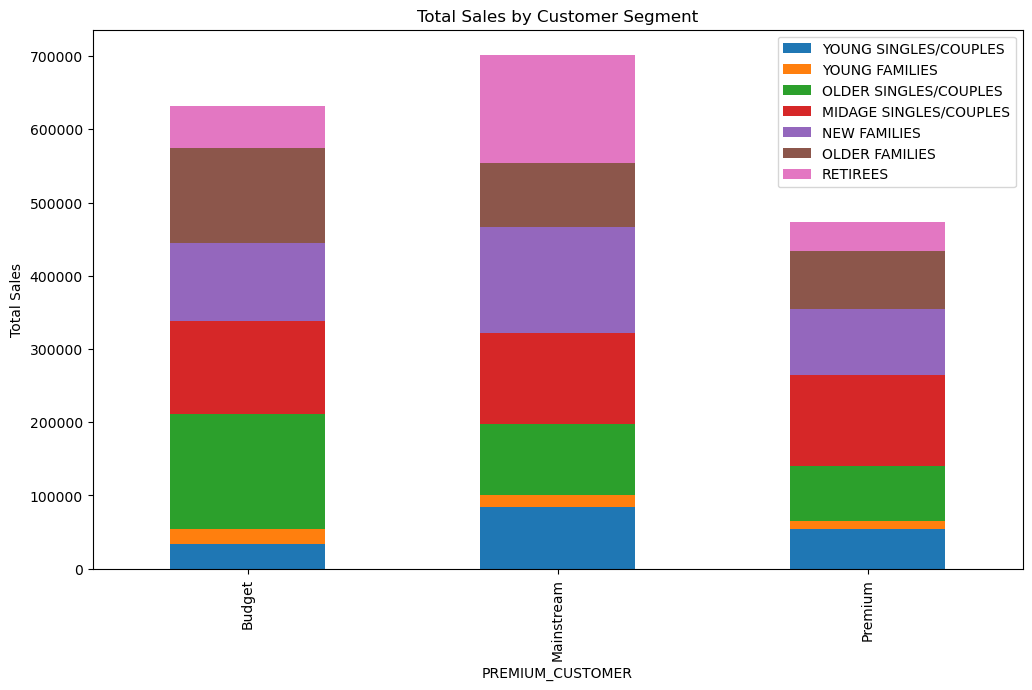

In [70]:
salesPlot = pd.DataFrame(data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).TOT_SALES.sum())
salesPlot.unstack().plot(kind = 'bar', stacked = True, figsize = (12, 7), title = 'Total Sales by Customer Segment')
plt.ylabel('Total Sales')
plt.legend(behaviour['LIFESTAGE'].unique(), loc = 1)

##### Insight: By comparing this plot to the plot of Number of customers by customer segment. It can be seen that there is no group that has low number of customers but contributes a lot sales.  That is, groups having more number of customers contributes higher sales and vise versa

##### Insights: Also, from the table above, it can be seen that the NEW FAMILIES in all three memberships contributes 1.1% of sales or less. 

 ### Total Sales group by customer-type and age-group

In [71]:
units = pd.DataFrame(data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).PROD_QTY.sum())
units.rename(columns = {'PROD_QTY': 'Total Units Per Group'}, inplace = True)
units.sort_values(by = 'Total Units Per Group', ascending = False, inplace = True)
units

Total Units Per Group
PREMIUM_CUSTOMER LIFESTAGE                                    
Budget           OLDER FAMILIES                          41853
Mainstream       RETIREES                                37677
                 YOUNG SINGLES/COUPLES                   36225
Budget           YOUNG FAMILIES                          34482
                 OLDER SINGLES/COUPLES                   32883
Mainstream       OLDER SINGLES/COUPLES                   32607
Premium          OLDER SINGLES/COUPLES                   31695
Budget           RETIREES                                26932
Mainstream       OLDER FAMILIES                          25804
Premium          RETIREES                                23266
Mainstream       YOUNG FAMILIES                          23194
                 MIDAGE SINGLES/COUPLES                  21213
Premium          YOUNG FAMILIES                          20901
                 OLDER FAMILIES                          20239
Budget           YOUNG SINGLES/COUPLES                   15500
Premium          MIDAGE SINGLES/COUPLES                  14400
                 YOUNG SINGLES/COUPLES                   10575
Budget           MIDAGE SINGLES/COUPLES                   8883
                 NEW FAMILIES                             5241
Mainstream       NEW FAMILIES                             4060
Premium          NEW FAMILIES                             2769

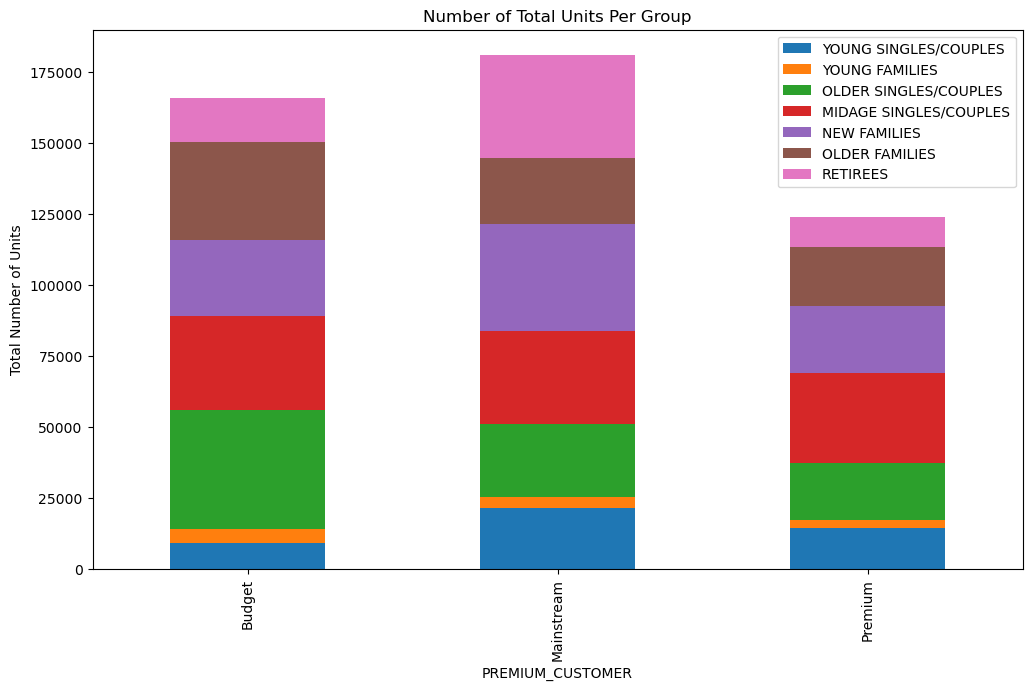

In [72]:
UnitsPlot = pd.DataFrame(data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).PROD_QTY.sum())
UnitsPlot.unstack().plot(kind = 'bar',stacked=True, figsize = (12, 7), title = 'Number of Total Units Per Group')
plt.ylabel('Total Number of Units')
plt.legend(behaviour['LIFESTAGE'].unique(), loc = 1)

### Average Price per unit by Customer Segment

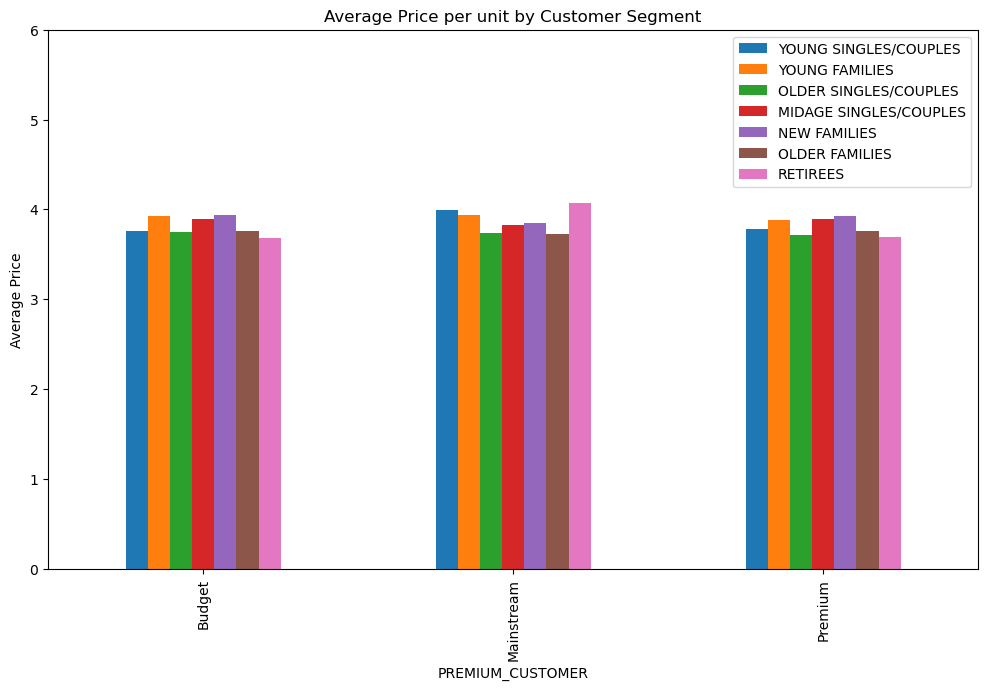

In [73]:
# Visualise 

avgPricePlot = pd.DataFrame(data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).TOT_SALES.sum() / data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).PROD_QTY.sum())
avgPricePlot.unstack().plot(kind = 'bar', figsize = (12, 7), title = 'Average Price per unit by Customer Segment', ylim = (0, 6))
plt.ylabel('Average Price')
plt.legend(behaviour['LIFESTAGE'].unique(), loc = 1)

##### Surprisingly, the premium group has the lowest sales,but have almost the same average units as other two groups. 
##### Insight: So Premium members contributes the least sales because they did not buy as many as other two groups of customers, the reason why Premium contributes the least sales is most likely that the number of Premium customer is low


###  Purchasing power per customer ?

In [74]:
avg_units = data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).PROD_QTY.sum() / data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).LYLTY_CARD_NBR.nunique()
avg_units = pd.DataFrame(avg_units, columns = {'Average Unit per Customer'})
avg_units.sort_values(by = 'Average Unit per Customer', ascending = False).head()

,,Average Unit per Customer
PREMIUM_CUSTOMER,LIFESTAGE,
Mainstream,OLDER FAMILIES,9.255380
Budget,OLDER FAMILIES,9.076773
Premium,OLDER FAMILIES,9.071717
Budget,YOUNG FAMILIES,8.722995
Premium,YOUNG FAMILIES,8.716013


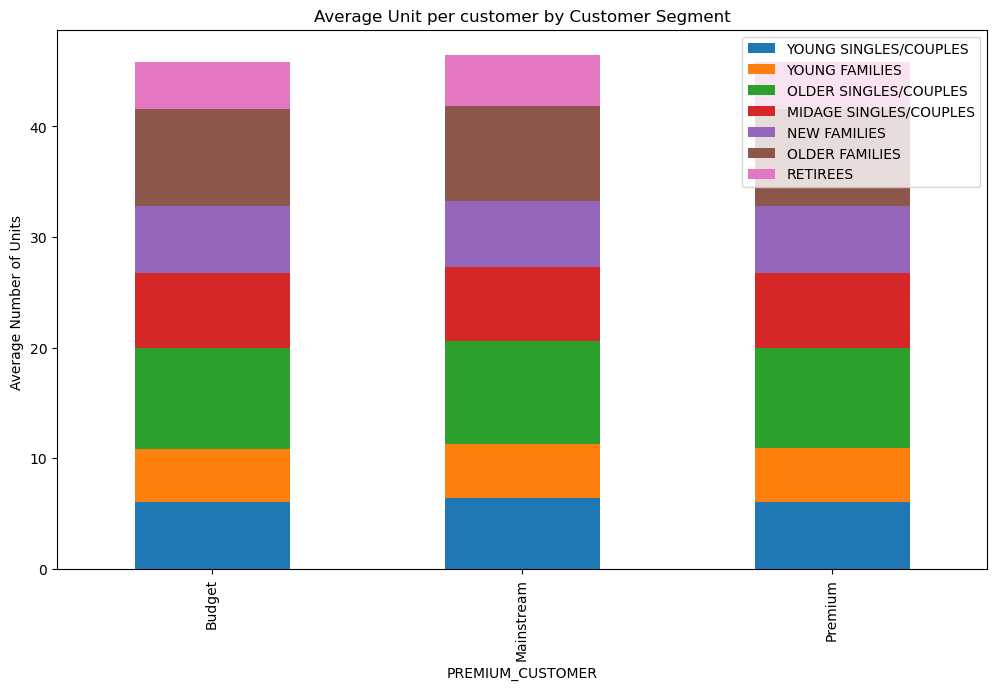

In [75]:
avgUnitsPlot = pd.DataFrame(data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).PROD_QTY.sum() / data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).LYLTY_CARD_NBR.nunique())
avgUnitsPlot.unstack().plot(kind = 'bar',stacked=True, figsize = (12, 7), title = 'Average Unit per customer by Customer Segment')
plt.ylabel('Average Number of Units ')
plt.legend(behaviour['LIFESTAGE'].unique(), loc = 1)

In [76]:
avg_price_by_person = data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).TOT_SALES.sum() / data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).LYLTY_CARD_NBR.nunique()
avg_price_by_person = pd.DataFrame(avg_price_by_person, columns = {'Price per person'})
avg_price_by_person.sort_values(by = 'Price per person', ascending = False).head()

,,Price per person
PREMIUM_CUSTOMER,LIFESTAGE,
Mainstream,OLDER FAMILIES,34.581618
Budget,OLDER FAMILIES,34.019464
Premium,OLDER FAMILIES,33.725952
Budget,YOUNG FAMILIES,32.815065
Premium,YOUNG FAMILIES,32.765513


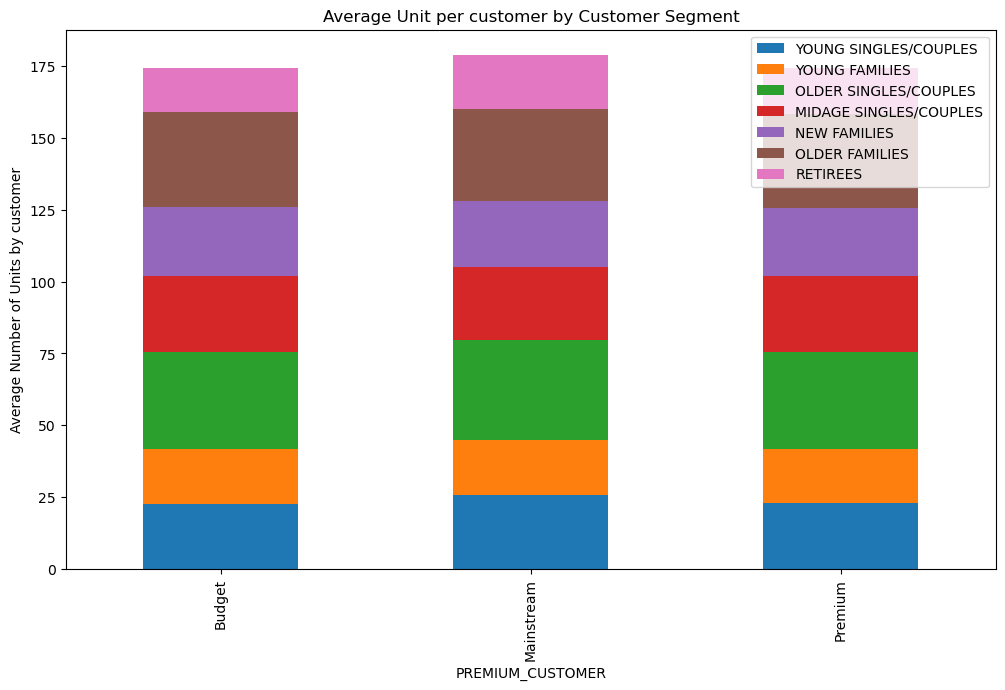

In [77]:
avgUnits_person_Plot = pd.DataFrame(data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).TOT_SALES.sum() / data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).LYLTY_CARD_NBR.nunique())
avgUnits_person_Plot.unstack().plot(kind = 'bar',stacked=True, figsize = (12, 7), title = 'Average Unit per customer by Customer Segment')
plt.ylabel('Average Number of Units by customer')
plt.legend(behaviour['LIFESTAGE'].unique(), loc = 1)

##### Insights
1. Three types of customers have almost the same purchasing power in terms of per-person units and per-person price. 
2. Mainstream midage and young singles and couples are more willing to pay more per packet of chips compared to their budget and premium counterparts. This may be due to premium shoppers being more likely to buy healthy snacks and when they do buy chips, it is mainly for entertainment purposes rather than their own consumption. This is also supported by there being fewer premium midage and young singles and couples buying chips compared to their mainstream counterparts.

### What brand and sizes do Mainstrem and Budget like

In [95]:
target = data.loc[(data['PREMIUM_CUSTOMER'] == 'Budget') | (data['PREMIUM_CUSTOMER']=='MAINSTREAM') , :]
nonTarget = data.loc[(data['PREMIUM_CUSTOMER'] != 'Budget') | (data['PREMIUM_CUSTOMER']!='MAINSTREAM') , :]

In [99]:
targetBrand = target.loc[:, ['BRAND', 'PROD_QTY']]

In [101]:
targetBrandCount = pd.DataFrame(targetBrand.groupby('BRAND')['PROD_QTY'].sum())

In [106]:
targetBrandCount= targetBrandCount.reset_index(level=['BRAND'])

In [108]:
targetBrandCount.sort_values("PROD_QTY",ascending=False, inplace=True)

In [109]:
targetBrandCount

,BRAND,PROD_QTY
10,Kettle,27200
16,Smiths,20953
5,Doritos,16796
13,Pringles,16541
18,Thins,9418
9,Infuzions,9408
14,RRD,8273
22,WW,7318
4,Cobs,6258
20,Twisties,6216


[Text(0, 0, '27200'),
 Text(0, 0, '20953'),
 Text(0, 0, '16796'),
 Text(0, 0, '16541'),
 Text(0, 0, '9418'),
 Text(0, 0, '9408'),
 Text(0, 0, '8273'),
 Text(0, 0, '7318'),
 Text(0, 0, '6258'),
 Text(0, 0, '6216'),
 Text(0, 0, '6194'),
 Text(0, 0, '4246'),
 Text(0, 0, '4214'),
 Text(0, 0, '4044'),
 Text(0, 0, '3170'),
 Text(0, 0, '3095'),
 Text(0, 0, '3043'),
 Text(0, 0, '2158'),
 Text(0, 0, '1987'),
 Text(0, 0, '1099'),
 Text(0, 0, '1068'),
 Text(0, 0, '1036'),
 Text(0, 0, '1025'),
 Text(0, 0, '1014')]

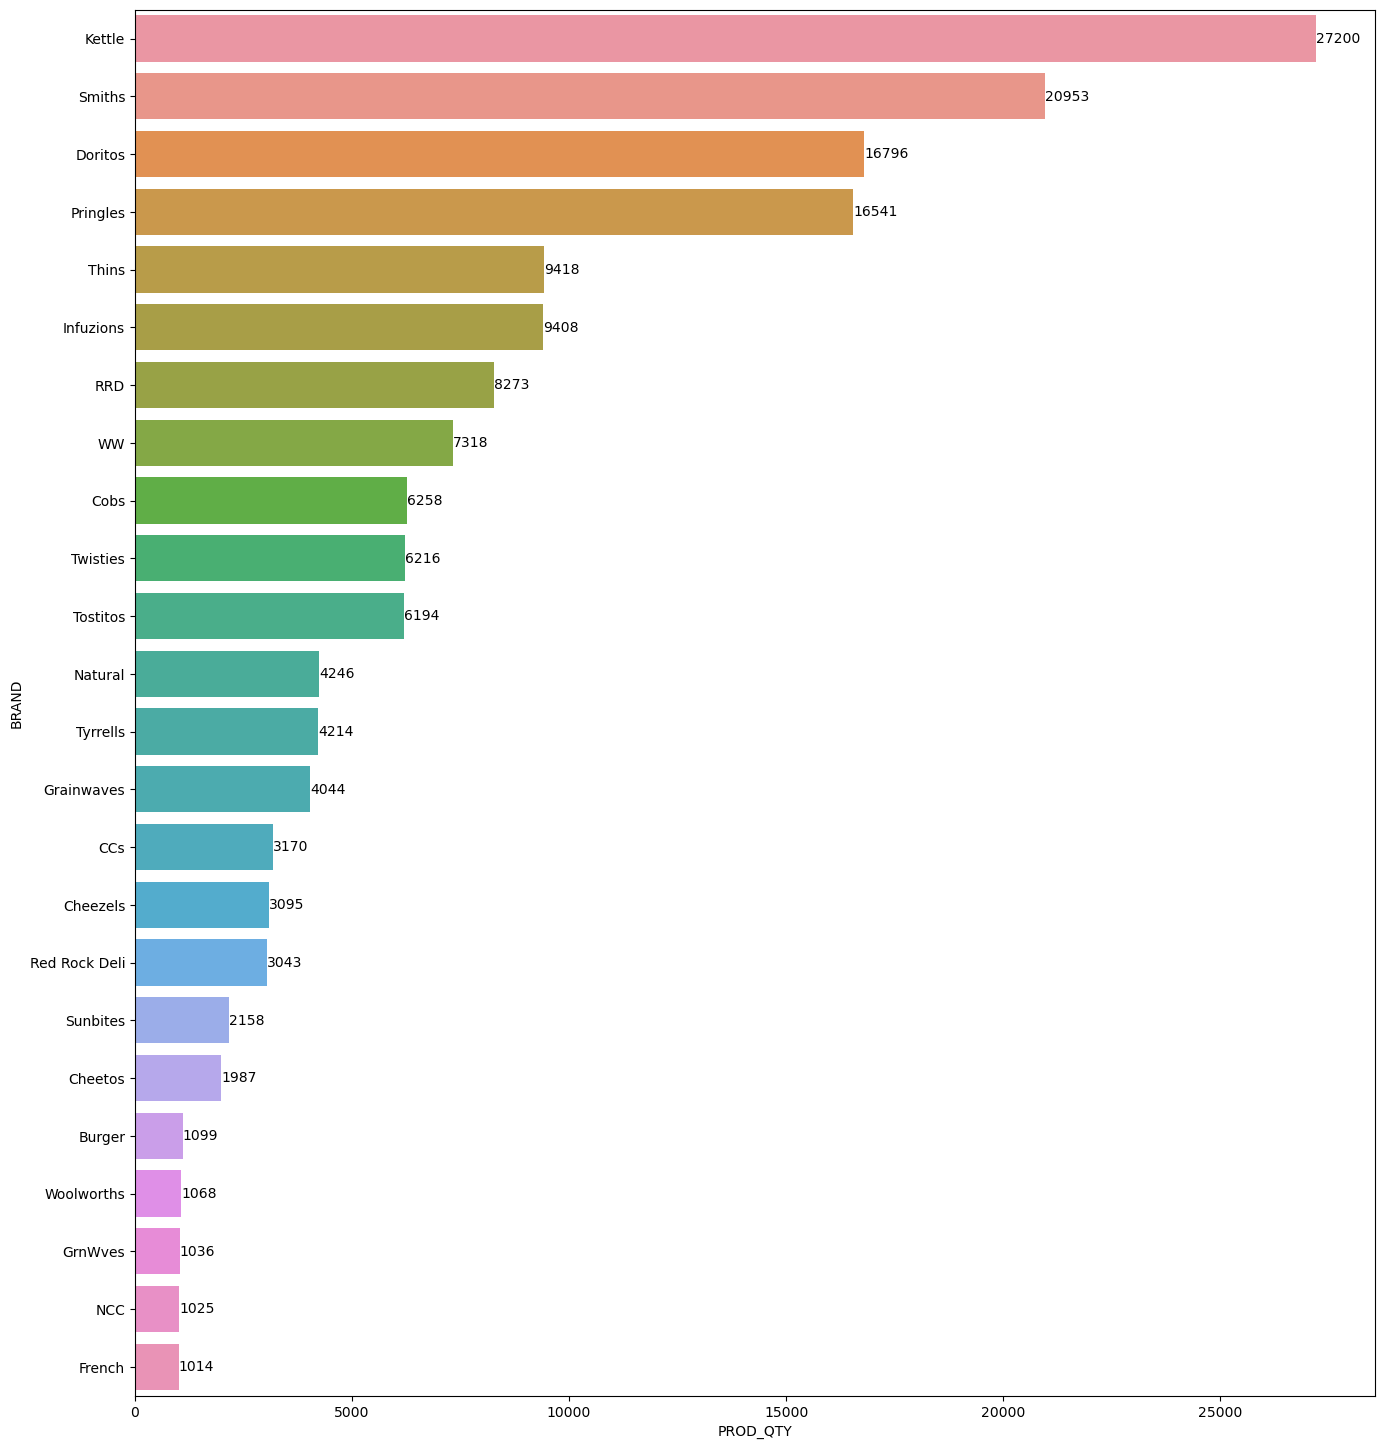

In [115]:
plt.figure(figsize = (16, 18))
ax = sns.barplot(data = targetBrandCount, x='PROD_QTY', y='BRAND', )
ax.bar_label(ax.containers[0])

In [122]:
print(list(targetBrandCount.BRAND))

['Kettle', 'Smiths', 'Doritos', 'Pringles', 'Thins', 'Infuzions', 'RRD', 'WW', 'Cobs', 'Twisties', 'Tostitos', 'Natural', 'Tyrrells', 'Grainwaves', 'CCs', 'Cheezels', 'Red Rock Deli', 'Sunbites', 'Cheetos', 'Burger', 'Woolworths', 'GrnWves', 'NCC', 'French']


In [117]:
targetBrandCount['Proportion'] = targetBrandCount['PROD_QTY']/targetBrandCount['PROD_QTY'].sum()

In [118]:
targetBrandCount['Proportion Sum'] = targetBrandCount.Proportion.cumsum()

In [119]:
targetBrandCount.sort_values("Proportion",ascending=False, inplace=True)

In [120]:
targetBrandCount

,BRAND,PROD_QTY,Proportion,Proportion Sum
10,Kettle,27200,0.164079,0.164079
16,Smiths,20953,0.126395,0.290474
5,Doritos,16796,0.101319,0.391792
13,Pringles,16541,0.099780,0.491573
18,Thins,9418,0.056812,0.548385
9,Infuzions,9408,0.056752,0.605137
14,RRD,8273,0.049905,0.655042
22,WW,7318,0.044144,0.699187
4,Cobs,6258,0.037750,0.736937
20,Twisties,6216,0.037497,0.774434


##### Note that Mainstream and Budget members typically prefer Kettle, Smiths, Doritos and Pringles. Brands including Kettle, Smiths, Doritos, Pringles, Thins, Infuzions, RRD, WW, Cobs, Twisties, Tostitos, Natural, Tyrrells', 'Grainwaves, CCs, Cheezels, Red Rock Deli, Sunbites, Cheetos contributes 96% of sales from Mainstream and Budget. Moreover, brands like Burger, Woolworths, GmWves, NCC and French contributes sales less than 1% respeitively for Mainstream and Budget members.

In [96]:
# Target Segment
targetBrand = target.loc[:, ['BRAND', 'PROD_QTY']]
targetSum = targetBrand['PROD_QTY'].sum()
targetBrand['Target Brand Affinity'] = targetBrand['PROD_QTY'] / targetSum
targetBrand = pd.DataFrame(targetBrand.groupby('BRAND')['Target Brand Affinity'].sum())

# Non-target segment
nonTargetBrand = nonTarget.loc[:, ['BRAND', 'PROD_QTY']]
nonTargetSum = nonTargetBrand['PROD_QTY'].sum()
nonTargetBrand['Non-Target Brand Affinity'] = nonTargetBrand['PROD_QTY'] / nonTargetSum
nonTargetBrand = pd.DataFrame(nonTargetBrand.groupby('BRAND')['Non-Target Brand Affinity'].sum())

In [97]:
brand_proportions = pd.merge(targetBrand, nonTargetBrand, left_index = True, right_index = True)
brand_proportions.head()

,Target Brand Affinity,Non-Target Brand Affinity
BRAND,,
Burger,0.006630,0.006314
CCs,0.019122,0.018301
Cheetos,0.011986,0.011756
Cheezels,0.018670,0.018595
Cobs,0.037750,0.039479


In [98]:
brand_proportions['Affinity to Brand'] = brand_proportions['Target Brand Affinity'] / brand_proportions['Non-Target Brand Affinity']
brand_proportions.sort_values(by = 'Affinity to Brand', ascending = False)

,Target Brand Affinity,Non-Target Brand Affinity,Affinity to Brand
BRAND,,,
French,0.006117,0.005619,1.088656
NCC,0.006183,0.005702,1.084464
Sunbites,0.013018,0.012100,1.075812
WW,0.044144,0.041371,1.067031
GrnWves,0.006249,0.005876,1.063584
Woolworths,0.006443,0.006105,1.055205
Natural,0.025613,0.024286,1.054658
Burger,0.006630,0.006314,1.050005
CCs,0.019122,0.018301,1.044856


### Affinity to Brand by mainstream young singles/couples, Budget Older Families and Budget Retirees

In [78]:
target = data.loc[((data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (data['PREMIUM_CUSTOMER'] == 'Mainstream')) | (((data['LIFESTAGE'] == 'OLDER FAMILIES') | (data['LIFESTAGE'] == 'RETIREES')) & (data['PREMIUM_CUSTOMER'] == 'Budget')) , :]
nonTarget = data.loc[((data['LIFESTAGE'] != 'YOUNG SINGLES/COUPLES') & (data['PREMIUM_CUSTOMER'] != 'Mainstream')) | (((data['LIFESTAGE'] != 'OLDER FAMILIES') | (data['LIFESTAGE'] == 'RETIREES')) & (data['PREMIUM_CUSTOMER'] == 'Budget')) , :]
target.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_WEIGHT,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
29896,2018-07-21,77,2330461,236777,87,infuzions bbq rib prawn crackers,1,3.8,110,Infuzions,OLDER FAMILIES,Budget
29897,2019-05-20,1,1367,424,7,smiths crinkle original,1,5.7,330,Smiths,OLDER FAMILIES,Budget
29898,2019-04-21,1,1367,422,82,smith crinkle cut mac n cheese,1,2.6,150,Smiths,OLDER FAMILIES,Budget
29899,2019-04-24,1,1367,423,51,doritos mexicana,2,8.8,170,Doritos,OLDER FAMILIES,Budget
29900,2018-08-17,3,3088,1462,89,kettle sweet chilli and sour cream,2,10.8,175,Kettle,OLDER FAMILIES,Budget


In [79]:
# Target Segment
targetBrand = target.loc[:, ['BRAND', 'PROD_QTY']]
targetSum = targetBrand['PROD_QTY'].sum()
targetBrand['Target Brand Affinity'] = targetBrand['PROD_QTY'] / targetSum
targetBrand = pd.DataFrame(targetBrand.groupby('BRAND')['Target Brand Affinity'].sum())

# Non-target segment
nonTargetBrand = nonTarget.loc[:, ['BRAND', 'PROD_QTY']]
nonTargetSum = nonTargetBrand['PROD_QTY'].sum()
nonTargetBrand['Non-Target Brand Affinity'] = nonTargetBrand['PROD_QTY'] / nonTargetSum
nonTargetBrand = pd.DataFrame(nonTargetBrand.groupby('BRAND')['Non-Target Brand Affinity'].sum())

In [80]:
targetBrand.head(5)

,Target Brand Affinity
BRAND,
Burger,0.005104
CCs,0.015789
Cheetos,0.010742
Cheezels,0.018912
Cobs,0.040463


In [81]:
nonTargetBrand.head(5)

,Non-Target Brand Affinity
BRAND,
Burger,0.006551
CCs,0.018782
Cheetos,0.011851
Cheezels,0.018864
Cobs,0.038205


In [82]:
# Merge the two dataframes together

brand_proportions = pd.merge(targetBrand, nonTargetBrand, left_index = True, right_index = True)
brand_proportions.head()

,Target Brand Affinity,Non-Target Brand Affinity
BRAND,,
Burger,0.005104,0.006551
CCs,0.015789,0.018782
Cheetos,0.010742,0.011851
Cheezels,0.018912,0.018864
Cobs,0.040463,0.038205


In [83]:
brand_proportions['Affinity to Brand'] = brand_proportions['Target Brand Affinity'] / brand_proportions['Non-Target Brand Affinity']
brand_proportions.sort_values(by = 'Affinity to Brand', ascending = False)

,Target Brand Affinity,Non-Target Brand Affinity,Affinity to Brand
BRAND,,,
Twisties,0.041291,0.037818,1.091831
Doritos,0.109085,0.100758,1.082639
Kettle,0.176878,0.165390,1.069464
Cobs,0.040463,0.038205,1.059085
Tyrrells,0.027178,0.025670,1.058769
Pringles,0.105609,0.100966,1.045984
Tostitos,0.039625,0.038023,1.042136
Grainwaves,0.025845,0.024828,1.040984
Thins,0.058204,0.057027,1.020642


In [84]:
print("Compared to the nonTarget, Target groups likes", list(brand_proportions[brand_proportions['Affinity to Brand']>1.01].index), "more")

Compared to the nonTarget, Target groups likes ['Cobs', 'Doritos', 'Grainwaves', 'Infuzions', 'Kettle', 'Pringles', 'Thins', 'Tostitos', 'Twisties', 'Tyrrells'] more


##### Insight: mainstream young singles/couples, Budget Older Families and Budget Retirees are more likely to purchase Cobs', 'Doritos', 'Grainwaves', 'Infuzions', 'Kettle', 'Pringles', 'Thins', 'Tostitos', 'Twisties', 'Tyrrells' chips compared to other brands.

### Affinity to pack size

In [85]:
 #Target segment 
targetSize = target.loc[:, ['PACK_WEIGHT', 'PROD_QTY']]
targetSum = targetSize['PROD_QTY'].sum()
targetSize['Target Pack Affinity'] = targetSize['PROD_QTY'] / targetSum
targetSize = pd.DataFrame(targetSize.groupby('PACK_WEIGHT')['Target Pack Affinity'].sum())

# Non-target segment
nonTargetSize = nonTarget.loc[:, ['PACK_WEIGHT', 'PROD_QTY']]
nonTargetSum = nonTargetSize['PROD_QTY'].sum()
nonTargetSize['Non-Target Pack Affinity'] = nonTargetSize['PROD_QTY'] / nonTargetSum
nonTargetSize = pd.DataFrame(nonTargetSize.groupby('PACK_WEIGHT')['Non-Target Pack Affinity'].sum())

In [86]:
# Merge the two dataframes together

pack_proportions = pd.merge(targetSize, nonTargetSize, left_index = True, right_index = True)
pack_proportions.head()

,Target Pack Affinity,Non-Target Pack Affinity
PACK_WEIGHT,,
70,0.004800,0.006372
90,0.010628,0.012744
110,0.093943,0.089054
125,0.005000,0.006107
134,0.105609,0.100966


In [87]:
pack_proportions['Affinity to Pack'] = pack_proportions['Target Pack Affinity'] / pack_proportions['Non-Target Pack Affinity']
pack_proportions.sort_values(by = 'Affinity to Pack', ascending = False)

,Target Pack Affinity,Non-Target Pack Affinity,Affinity to Pack
PACK_WEIGHT,,,
270,0.027616,0.024921,1.108167
330,0.055823,0.050555,1.104214
380,0.027474,0.025480,1.078247
250,0.013675,0.012898,1.060265
110,0.093943,0.089054,1.054903
135,0.013475,0.012858,1.047963
134,0.105609,0.100966,1.045984
210,0.025845,0.024828,1.040984
170,0.082002,0.080579,1.017660


In [88]:
print("Compared to the nonTarget, Target groups likes", list(pack_proportions[pack_proportions['Affinity to Pack']>1.01].index), "more")

Compared to the nonTarget, Target groups likes [110, 134, 135, 170, 210, 250, 270, 330, 380] more


##### Insight: It looks like mainstream young singles/couples, Budget Older Families and Budget Retirees are more likely to purchase a 110g, 134g, 135g, 170g, 210g, 250g, 270g, 33g0, 380g and 270g pack size compared to other pack sizes.

In [ ]:
### Sales Drop analysis

In [166]:
mainstream = data.loc[data['PREMIUM_CUSTOMER'] == 'Mainstream', :].groupby(['LYLTY_CARD_NBR']).TXN_ID.count()

In [167]:
mainstream

LYLTY_CARD_NBR
1002       1
1004       1
1005       1
1010       1
1011       3
          ..
2330431    1
2370181    1
2370651    1
2370701    1
2373711    1
Name: TXN_ID, Length: 28734, dtype: int64

Conclusion

Overall:
1.	In terms of demongraphic of members:

    a.	By membership types: About 73% of members are Budget or Mainstream. Particularly, 40% of members are Mainstream
    
    b.	By lifestage:  Almost 60%  menbers are Retirees, older singles/couples and Young singles/couples. Particularly, 20% members are retirees (the age group that is the largest proportion) and only 3% members are new family


2.	In terms of Sales:

    a.	Generally speaking, the sales does not show an obvious upward or downward trend although there exist two significant drop fall in August 2018, Chrismas Day in 2018 and June 2019. (Further analysis required)
    
    b.	Membership groups (or age groups )having more number of customers contributes higher sales and vise versa. It can be seen that the NEW FAMILIES in all three memberships contributes 1.1% of sales or less.
    
    c.	Mainstream and Budget members contributes the major proportion to the sales (To be more specific, mainstream members contributes the largest proportion of sales).
    
    
Interesting facts about the customer analytics:
1.	In terms of purchasing power (measured by the number of units purchased per member or price paid per member)

    a. Mainstream, Budget and Premium have almost the same purchasing power in terms of per-person units and per-person price. 
    
    b. Mainstream midage and young singles and couples are more willing to pay more per packet of chips compared to their budget and premium counterparts. This may be due to premium shoppers being more likely to buy healthy snacks and when they do buy chips, it is mainly for entertainment purposes rather than their own consumption. This is also supported by there being fewer premium midage and young singles and couples buying chips compared to their mainstream counterparts.
    
    c. Surprisingly, the premium group has the lowest sales,but have almost the same average units as other two groups. So Premium members contributes the least sales because they did not buy as many as other two groups of customers, the reason why Premium contributes the least sales is most likely that the number of Premium customer is low


2.	Mainstream and Budget members’ preferences to brand:

    a.	Note that Mainstream and Budget members typically prefer Kettle, Smiths, Doritos and Pringles. Brands including Kettle, Smiths, Doritos, Pringles, Thins, Infuzions, RRD, WW, Cobs, Twisties, Tostitos, Natural, Tyrrells', 'Grainwaves, CCs, Cheezels, Red Rock Deli, Sunbites, Cheetos contributes 96% of sales from Mainstream and Budget. Moreover, brands like Burger, Woolworths, GmWves, NCC and French contributes sales less than 1% respeitively for Mainstream and Budget members. 
